# Desafio de programação 2: Regressão Logística

## Identificação:

**Nome:** Rodrigo reis dos santos

**Matrícula:** 222026546

## Introdução

Neste exercício, nós iremos implementar a regressão logística e aplicá-la em dois diferentes datasets.

Todas as informações necessárias para resolver esta tarefa estão neste ambiente, e todas as partes do código devem ser implementadas ao longo deste notebook.

Antes de iniciarmos o exercício, nós precisamos que algumas bibliotecas já estejam disponíveis. São elas:

- Numpy: (http://www.numpy.org/) para todas as operações matriciais;
- Matplotlib: (https://matplotlib.org/) para a plotagem dos gráficos;
- Scipy(https://docs.scipy.org/doc/scipy/reference/) que contém funções e ferramentas de cálculo numérico e científico.

Mas antes, nós configuraremos o ambiente, permitindo o acesso ao seu Google Drive, de onde serão importados os datasets e as imagens do notebook, além de outros módulos adicionais.


In [1]:
#allows the drive to be accessed
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import sys

!unzip -q "/content/drive/MyDrive/TopEng/DP2/Utilidades-TP2.zip"
!cat '/content/drive/My Drive/TopEng/DP2/utils.py'
sys.path.append('/content/drive/My Drive/TopEng/DP2')

import sys
import numpy as np
from matplotlib import pyplot


def mapFeature(X1, X2, degree=6):
    """
    Maps the two input features to quadratic features used in the regularization exercise.

    Returns a new feature array with more features, comprising of
    X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..

    Parameters
    ----------
    X1 : array_like
        A vector of shape (m, 1), containing one feature for all examples.

    X2 : array_like
        A vector of shape (m, 1), containing a second feature for all examples.
        Inputs X1, X2 must be the same size.

    degree: int, optional
        The polynomial degree.

    Returns
    -------
    : array_like
        A matrix of of m rows, and columns depend on the degree of polynomial.
    """
    if X1.ndim > 0:
        out = [np.ones(X1.shape[0])]
    else:
        out = [np.ones(1)]

    for i in range(1, degree + 1):
        for j in range(i + 1):
            out.append((X1 ** (i - j)) * (X2 ** j))

    if X1.ndim >

In [3]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# library written for this exercise providing additional functions for assignment submission, and others
import utils

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## 1 Regressão logística

Nesta parte do exercício, nós construiremos um modelo de regressão logística para prever se um estudante será aprovado ou não na universidade. Suponha que você é o administrador de um departamento de uma universidade e você quer avaliar a chance de admissão de cada um dos candidatos, baseado nos resultados destes em duas provas. Você possui o histórico com essas duas notas de cada candidato e usará esses dados como treinamento da regressão logística.

Em cada exemplo, você possui as notas dos candidatos nas provas e as decisões quanto à admissão destes. A nossa tarefa é construir um modelo de classificação que estime a probabilidade de admissão de cada candidato baseado nas notas dos dois exames.

A próxima célula carregará os dados de treinamento (com as nota dos dois exames) e os seus resultados (admitido ou não).

In [135]:
# Load data
# The first two columns contains the exam scores and the third column
# contains the label.
data = np.loadtxt(os.path.join('Utilidades/Data', 'ex2data1.txt'), delimiter=',')
X, y = data[:, 0:2], data[:, 2]

### 1.1 Visualização de dados

Antes de iniciarmos a implementação de qualquer algoritmo de aprendizado, é sempre aconselhável visualizar os dados, se for possível. Nós mostraremos os dados em uma plotagem bidimensional chamando a função `plotData`. Você deve completar o código `plotData` e então ele mostrará uma figura em que os eixos são as notas das duas provas, e os exemplos positivos e negativos são mostrados em diferentes marcadores.

Para ajudar você a ganhar familiaridade com a plotagem, nós deixamos `plotData` em branco para que você tente implementar por você. Entretanto, este é um exercício opcional (não avaliado) e, por isso, nós fornecemos a implementação abaixo. Se você precisar copiar o nosso código, tenha certeza que você aprendeu o que cada comando executa. Isto pode ser feito acessando a documentação das bibliotecas `matplotlib` e `numpy`.

```python
    # Find Indices of Positive and Negative Examples
    pos = y == 1
    neg = y == 0

    # Plot Examples
    pyplot.plot(X[pos, 0], X[pos, 1], 'k*', lw=2, ms=10)
    pyplot.plot(X[neg, 0], X[neg, 1], 'ko', mfc='y', ms=8, mec='k', mew=1)
```

In [136]:
def plotData(X, y):
    """
    Plots the data points X and y into a new figure. Plots the data
    points with * for the positive examples and o for the negative examples.

    Parameters
    ----------
    X : array_like
        An Mx2 matrix representing the dataset.

    y : array_like
        Label values for the dataset. A vector of size (M, ).

    Instructions
    ------------
    Plot the positive and negative examples on a 2D plot, using the
    option 'k*' for the positive examples and 'ko' for the negative examples.
    """
    # Create New Figure
    fig = pyplot.figure()

    # ====================== YOUR CODE HERE ======================
    pos = (y == 1).flatten()
    neg = (y == 0).flatten()

    pyplot.plot(X[pos, 0], X[pos, 1], 'k*', markersize=8, label='Positive')
    pyplot.plot(X[neg, 0], X[neg, 1], 'ko', markerfacecolor='y', markersize=8, label='Negative')


    # ============================================================

Agora, nós chamaremos a função implementada que plotará os dados carregados:

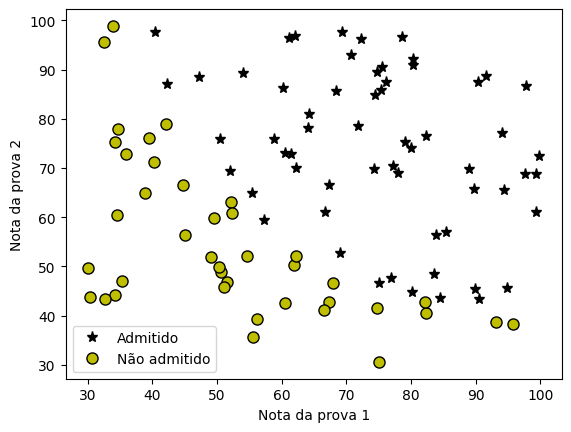

In [137]:
plotData(X, y)
# add axes labels
pyplot.xlabel('Nota da prova 1')
pyplot.ylabel('Nota da prova 2')
pyplot.legend(['Admitido', 'Não admitido'])
pass

<a id="section1"></a>
### 1.2 Implementação

#### 1.2.1 Exercício de aquecimento: Função sigmoid

Antes de iniciarmos com a função de custo, relembre que a hipótese da regressão logística é definida como:

$$ h_\theta(x) = g(\theta^T x)$$

em que a função $g$ é a função sigmoid, que é definida como:

$$g(z) = \frac{1}{1+e^{-z}}$$.

O primeiro passo é implementar a função `sigmoid` e, então, ela poderá ser chamada pelo resto do nosso programa. Quanto você finalizar, tente testar alguns valores chamando `sigmoid(x)` em uma nova célula. Para valores muito positivos de `x`, a sigmoid deve se aproximar de 1, ao passo que, para valores muito negativos, a sigmoid deve se aproximar de 0. A função `sigmoid(0)` deve ser exatamente 0.5.

Seu código deve funcionar tanto para z na forma de matrizes unidimensionais (vetores), quanto bidimensionais (neste último caso, o código deve executar a função sigmoid em todos os elementos)
<a id="sigmoid"></a>

A correta implementação desta função lhe agregará **10 pontos** dentro da pontuação total deste Desafio de Programação.

In [138]:
def sigmoid(z):
    """
    Compute sigmoid function given the input z.

    Parameters
    ----------
    z : array_like
        The input to the sigmoid function. This can be a 1-D vector
        or a 2-D matrix.

    Returns
    -------
    g : array_like
        The computed sigmoid function. g has the same shape as z, since
        the sigmoid is computed element-wise on z.

    Instructions
    ------------
    Compute the sigmoid of each value of z (z can be a matrix, vector or scalar).
    """
    # convert input to a numpy array
    z = np.array(z)

    # You need to return the following variables correctly
    g = np.zeros(z.shape)

    # ====================== YOUR CODE HERE ======================
    g = 1 / (1 + np.exp(-z))

    # =============================================================
    return g

A próxima célula avalia a função sigmoid para `z=0`. Ela deve retornar um valor de 0.5. Você também deve testar a sua função para diferentes valores de `z`.

In [139]:
# Test the implementation of sigmoid function here
z = 0
g = sigmoid(z)

print('g(', z, ') = ', g)

g( 0 ) =  0.5


Além disso, é importante visualizar o gráfico da função sigmoid e comparar com aqueles vistos na literatura. Abaixo, plotamos o gráfico da função para alguns valores arbitrários.

Text(0, 0.5, 'y')

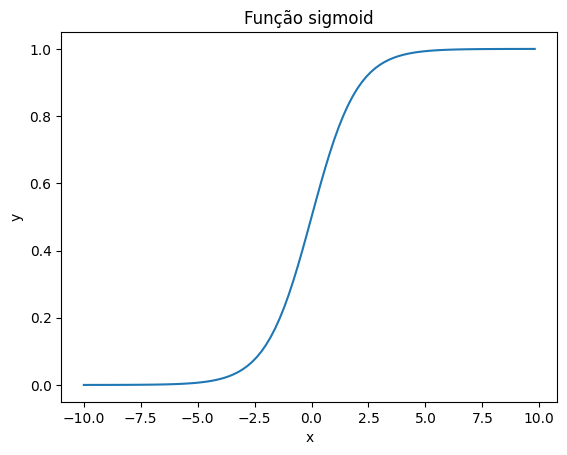

In [140]:
x = np.arange(-10, 10, 0.2)
y = sigmoid(x)

pyplot.plot(x, y)
pyplot.title('Função sigmoid')
pyplot.xlabel('x')
pyplot.ylabel('y')

<a id="section2"></a>
#### 1.2.2 Função de custo e gradiente

Agora nós iremos implementar a função de custo e gradiente para regressão logística. Antes de iniciar, nós adicionamos o termo de interceptação em X.

In [141]:
# Setup the data matrix appropriately, and add ones for the intercept term
m, n = X.shape

# Add intercept term to X
X = np.concatenate([np.ones((m, 1)), X], axis=1)

Agora vamos completar o código para a função `costFunction` para retornar o custo e o gradiente. Perceba que a função de custo na regressão logística é

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(h_\theta\left( x^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - h_\theta\left( x^{(i)} \right) \right) \right]$$

e o gradiente do custo é um vetor com o mesmo tamanho de $\theta$ em que o $j$-ésimo elemento (para $j = 0, 1, \cdots , n$) é definido como:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} $$

Note que apesar de o gradiente parecer idêntico ao da regressão linear, a fórmula é, na verdade, diferente, já que as regressões logística e linear possuem diferentes definições de $h_\theta(x)$.

<a id="costFunction"></a>

A correta implementação desta função lhe agregará **40 pontos** dentro da pontuação total deste Desafio de Programação.

In [151]:
def costFunction(theta, X, y):
    """
    Compute cost and gradient for logistic regression.

    Parameters
    ----------
    theta : array_like
        The parameters for logistic regression. This a vector
        of shape (n+1, ).

    X : array_like
        The input dataset of shape (m x n+1) where m is the total number
        of data points and n is the number of features. We assume the
        intercept has already been added to the input.

    y : arra_like
        Labels for the input. This is a vector of shape (m, ).

    Returns
    -------
    J : float
        The computed value for the cost function.

    grad : array_like
        A vector of shape (n+1, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.

    Instructions
    ------------
    Compute the cost of a particular choice of theta. You should set J to
    the cost. Compute the partial derivatives and set grad to the partial
    derivatives of the cost w.r.t. each parameter in theta.
    """
    # Initialize some useful values
    m = y.size  # number of training examples

    # You need to return the following variables correctly
    J = 0
    grad = np.zeros(theta.shape)

    # ====================== YOUR CODE HERE ======================
    h = sigmoid(np.dot(X, theta))

    J = (1 / m) * np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h))

    grad = (1 / m) * np.dot(X.T, (h - y))


    # =============================================================
    return J, grad

Uma vez terminada, chame a função `costFunction` utilizando dois exemplos de teste para $\theta$ executando a próxima célula.

In [152]:
# Initialize fitting parameters
n = X.shape[1] - 1
initial_theta = np.zeros(n+1)

cost, grad = costFunction(initial_theta, X, y)

print('Custo com o theta inicial (zeros): {:.3f}'.format(cost))
print('Custo esperado (aproximado): 0.693\n')

print('Gradiente com o theta inicial (zeros):')
print('\t[{:.4f}, {:.4f}, {:.4f}]'.format(*grad))
print('Gradiente esperado (aproximado):\n\t[-0.1000, -12.0092, -11.2628]\n')

# Compute and display cost and gradient with non-zero theta
test_theta = np.array([-24, 0.2, 0.2])
cost, grad = costFunction(test_theta, X, y)

print('Custo com o theta de teste: {:.3f}'.format(cost))
print('Custo esperado (aproximado): 0.218\n')

print('Gradiente com o theta de teste:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*grad))
print('Gradiente esperado (aproximado):\n\t[0.043, 2.566, 2.647]')

Custo com o theta inicial (zeros): 0.693
Custo esperado (aproximado): 0.693

Gradiente com o theta inicial (zeros):
	[0.0050, -0.1934, -0.9500]
Gradiente esperado (aproximado):
	[-0.1000, -12.0092, -11.2628]

Custo com o theta de teste: 2.124
Custo esperado (aproximado): 0.218

Gradiente com o theta de teste:
	[0.148, 14.382, 12.960]
Gradiente esperado (aproximado):
	[0.043, 2.566, 2.647]


#### 1.2.3 Aprendizado de parâmetros utilizando `scipy.optimize`

No último Desafio de Programação, nós encontramos os parâmetros ótimos do modelo de regressão linear a partir da implementação do gradient descent. Nós escrevemos a função de custo e calculamos o seu gradiente, ajustando-o a cada passo. Desta vez, ao invés de fazer os passos do gradient descent, nós usaremos o [`scipy.optimize` module](https://docs.scipy.org/doc/scipy/reference/optimize.html).

Scipy é uma biblioteca de cálculo numérico para `python`. Nela, há um módulo de otimização através de algoritmos para encontrar raiz e minimalização. A partir do `scipy 1.0`, a função `scipy.optimize.minimize` será o método utilizado para problemas de otimização.

Para regressão logística, você quer otimizar a função de custo $J(\theta)$ com parâmetros $\theta$.
De forma concreta, nós usaremos `optimize.minimize` para encontrar os melhores parâmetros $\theta$ para a função de custo e gradiente da regressão logística para o dataset (X,y). Você irá passar como entradas de `optimize.minimize`:
- `costFunction`: Uma função de custo que, quando recebe um conjunto de treinamento e um $\theta$ particular, calcula o custo e o gradiente da regressão logística levando em consideração $\theta$ para o dataset (X, y). É importante notar que nós passamos o nome da função sem os parênteses. Isto indica que estamos apenas referenciando esta função e não avaliando os resultados dela;
- `initial_theta`: Os valores iniciais dos parâmetros que estamos tentando otimizar;
- `(X, y)`: argumentos adicionais da função de custo;
- `jac`: Indicação se a função de custo retornará um Jacobiano (gradiente) ao longo de um valor de custo. (True)
- `method`: Método/algoritmo de otimização utilizado;
- `options`: opções adicionais que são específicas do método de otimização escolhido. Neste caso, nós apenas selecionamos o número de iterações que serão realizadas.

Se você tiver completado a função `costFunction` corretamente, `optimize.minimize` convergirá para os parâmetros de otimização corretos e retornarão os valores finais do custo e do $\theta$ em uma variável de tipo 'class'. Repare que usando `optimize.minimize` você não precisa escrever nenhum loop próprio, nem sequer selecionar uma taxa de aprendizado como feito para o gradient descent.

Com tudo isso já sendo realizado pela função `optimize.minimize`, você deve apenas fornecer a função que calculará o custo e o gradiente. Na próxima célula, nós já escrevemos o código de `optimize.minimize` com os argumentos corretos.

In [153]:
# set options for optimize.minimize
options= {'maxiter': 400}

# see documention for scipy's optimize.minimize  for description about
# the different parameters
# The function returns an object `OptimizeResult`
# We use truncated Newton algorithm for optimization which is
# equivalent to MATLAB's fminunc
# See https://stackoverflow.com/questions/18801002/fminunc-alternate-in-numpy
res = optimize.minimize(costFunction,
                        initial_theta,
                        (X, y),
                        jac=True,
                        method='TNC',
                        options=options)

# the fun property of `OptimizeResult` object returns
# the value of costFunction at optimized theta
cost = res.fun

# the optimized theta is in the x property
theta = res.x

# Print theta to screen
print('Custo em theta encontrado pelo optimize.minimize: {:.3f}'.format(cost))
print('Custo esperado (aproximado): 0.203\n');

print('Theta:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*theta))
print('Theta esperado (aproximado):\n\t[-25.161, 0.206, 0.201]')

Custo em theta encontrado pelo optimize.minimize: 0.682
Custo esperado (aproximado): 0.203

Theta:
	[-1.432, 0.006, 0.015]
Theta esperado (aproximado):
	[-25.161, 0.206, 0.201]


<ipython-input-153-45745cdbc1ea>:10: OptimizeWarning: Unknown solver options: maxiter
  res = optimize.minimize(costFunction,


Uma vez que a função `optimize.minimize` esteja finalizada, nós pretendemos utilizar o valor final de $\theta$ para visualizar os limites de decisão dos dados de treinamento, como mostrado na figura abaixo.

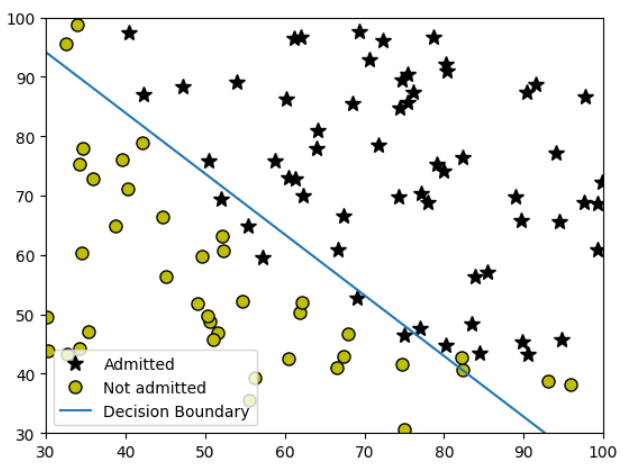

Para fazer isso, nós escrevemos a função `plotDecisionBoundary` para plotar os limites de decisão nesses dados. Você não precisa escrever nenhum código para plotar o limite de decisão, mas é indicado que você leia o código no arquivo `utils.py` que está disponível nesta pasta.

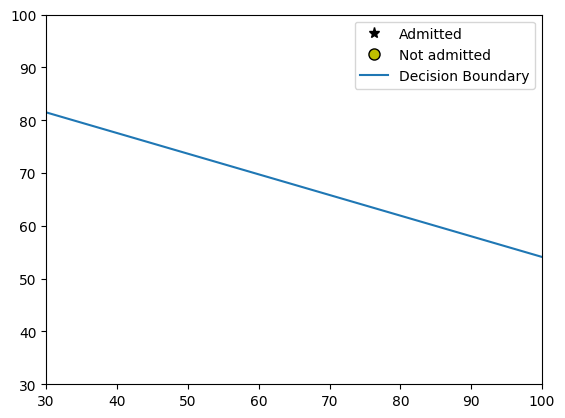

In [154]:
# Plot Boundary
utils.plotDecisionBoundary(plotData, theta, X, y)

<a id="section4"></a>
#### 1.2.4 Avaliando a regressão logística

Após o aprendizado dos parâmetros, nós podemos utilizar o modelo para prever se um estudante, em específico, será admitido ou não. Para um estudante com a nota da Prova 1 igual a 45 e da Prova 2 igual a 85, nós devemos prever uma probabilidade de admissão igual a 0,776. Outra forma de validar a qualidade dos parâmetros encontrados é observar se as previsões do nosso modelo de aprendizado são próximas do esperado para os nossos dados de treinamento.

Nesta parte, a sua tarefa é completar o código da função `predict`. Esta função produzirá um valor binário ("1" ou "0") como previsão, a partir de um dataset e do vetor de parâmetros $\theta$ já treinado.
<a id="predict"></a>

A correta implementação desta função lhe agregará **20 pontos** dentro da pontuação total deste Desafio de Programação.

In [91]:
def predict(theta, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression.
    Computes the predictions for X using a threshold at 0.5
    (i.e., if sigmoid(theta.T*x) >= 0.5, predict 1)

    Parameters
    ----------
    theta : array_like
        Parameters for logistic regression. A vecotor of shape (n+1, ).

    X : array_like
        The data to use for computing predictions. The rows is the number
        of points to compute predictions, and columns is the number of
        features.

    Returns
    -------
    p : array_like
        Predictions and 0 or 1 for each row in X.

    Instructions
    ------------
    Complete the following code to make predictions using your learned
    logistic regression parameters.You should set p to a vector of 0's and 1's
    """
    m = X.shape[0] # Number of training examples

    # You need to return the following variables correctly
    p = np.zeros(m)

    # ====================== YOUR CODE HERE ======================
    probabilidade = sigmoid(np.dot(X, theta))

    p = (probabilidade >= 0.5).astype(int)

    # ============================================================
    return p

Após completar o código de `predict`, nós produziremos os valores de acurácia de treinamento do nosso classificador. A acurácia pode ser definida como a porcentagem de previsões corretas dentre todas previsões feitas pelo classificador. Em termos matemáticos:

$$ acc = \frac{correct}{T}$$

em que T é o total de previsões feitas pelo classificador e correct são apenas aquelas que ele acertou.

Na célula abaixo, executaremos o código para o cálculo da acurácia.

In [92]:
#  Predict probability for a student with score 45 on exam 1
#  and score 85 on exam 2
prob = sigmoid(np.dot([1, 45, 85], theta))
print('Para um aluno com notas iguais a 45 e 85,'
      ' nós prevemos uma probabilidade de admissão igual a {:.3f}'.format(prob))
print('Valor esperado: 0.775 +/- 0.002\n')

# Compute accuracy on our training set
p = predict(theta, X)
print('Acurácia de treino: {:.2f} %'.format(np.mean(p == y) * 100))
print('Acurácia esperada (aproximada): 89.00 %')

Para um aluno com notas iguais a 45 e 85, nós prevemos uma probabilidade de admissão igual a 0.536
Valor esperado: 0.775 +/- 0.002

Acurácia de treino: 0.00 %
Acurácia esperada (aproximada): 89.00 %


## 2 Regressão logística regularizada

Nesta parte do exercício, nós implementaremos a regressão logística regularizada para prever se microchips de um fabricante serão aceitos no exame de garantia de qualidade. Nesse exame, cada microchip passa por vários testes, visando garantir o seu correto funcionamento.

Suponha que você é o gerente de produção da fábrica e você possui os resultados de dois testes para alguns microchips. Para esses dois testes, você deve determinar se os microchips devem ser aceitos ou rejeitados. Para ajudar na tomada de decisão, você terá um dataset com os resultados dos testes de microships anteriores, a partir do qual você poderá construir um modelo de regressão logística.

Primeiro, nós carregaremos os dados do arquivo CSV:

In [119]:
# Load Data
# The first two columns contains the X values and the third column
# contains the label (y).
data = np.loadtxt(os.path.join('Utilidades/Data', 'ex2data2.txt'), delimiter=',')
X = data[:, :2]
y = data[:, 2]

### 2.1 Visualização de dados

De forma similar ao que foi feito nas partes anteriores deste exercício, `plotData` é utilizado para gerar uma figura em que os eixos são as notas dos dois testes, e os exemplos positivos (y = 1, aceito) e negativos (y = 0, rejeitado) são mostrados com marcadores diferentes.

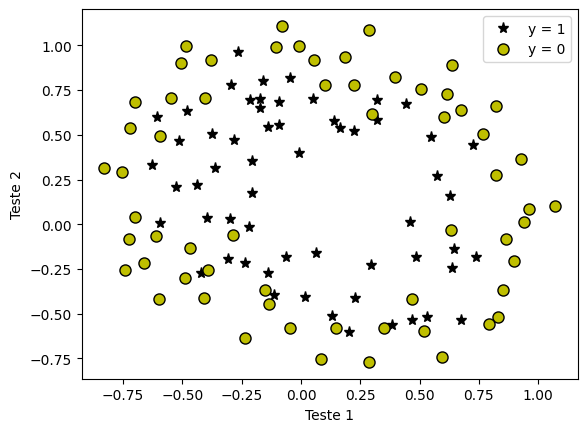

In [120]:
plotData(X, y)
# Labels and Legend
pyplot.xlabel('Teste 1')
pyplot.ylabel('Teste 2')

# Specified in plot order
pyplot.legend(['y = 1', 'y = 0'], loc='upper right')
pass

A figura de cima mostra que o nosso dataset não está dividido em exemplos positivos e negativos por uma linha reta através da plotagem. Portanto, a aplicação direta da regressão logística não terá uma boa performance neste dataset, uma vez que esta técnica só é capaz de encontrar um limite de decisão que seja linear.

### 2.2 Mapeamento de features

Uma forma de ajustar melhor os dados é criar mais features para cada dado. Na função `mapFeature` definida no arquivo `utils.py`, nós iremos mapear as features em todos os termos polinomiais de $x_1$ e $x_2$ até a sexta potência.

$$ \text{mapFeature}(x) = \begin{bmatrix} 1 & x_1 & x_2 & x_1^2 & x_1 x_2 & x_2^2 & x_1^3 & \dots & x_1 x_2^5 & x_2^6 \end{bmatrix}^T $$

Como resultado deste mapeamento, nosso vetor com duas features (as notas dos dois testes de qualidade) foi transformado em um vetor de 28 dimensões. Um classificador por regressão logística treinado com esse vetor de dimensão alta possui um limite de decisão mais complexo e, por isso, parecerá não linear quando desenhado em uma gráfico bidimensional (2-D).

Apesar de o mapeamento de features permitir a construção de um classificador mais robusto, a sua utilização também torna o modelo mais suscetível ao overfitting. Nas próximas partes do exercício, nós iremos implementar uma regressão logística regularizada para ajustar os dados e, assim, poderemos perceber como a regularização pode solucionar o problema de overfitting.


In [121]:
# Note that mapFeature also adds a column of ones for us, so the intercept
# term is handled
X = utils.mapFeature(X[:, 0], X[:, 1])

<a id="section5"></a>
### 2.3 Função de custo e gradiente

Agora nós implementaremos o código para calcular a função de custo e o gradiente para a regressão logística regularizada. Complete o código para a função `costFunctionReg` abaixo, que retornará o custo e o gradiente.

Repare que a função de custo regularizada na regressão logística é

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)}\log \left( h_\theta \left(x^{(i)} \right) \right) - \left( 1 - y^{(i)} \right) \log \left( 1 - h_\theta \left( x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

Note que você NÃO deve regularizar os parâmetros $\theta_0$. O gradiente da função de custo é um vetor em que o $j^{th}$ elemento é definido como:
$$ \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \qquad \text{para  } j =0 $$

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m}\theta_j \qquad \text{para  } j \ge 1 $$
<a id="costFunctionReg"></a>

A correta implementação desta função lhe agregará **30 pontos** dentro da pontuação total deste Desafio de Programação.

In [122]:
def costFunctionReg(theta, X, y, lambda_):
    """
    Compute cost and gradient for logistic regression with regularization.

    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ). n is
        the number of features including any intercept. If we have mapped
        our initial features into polynomial features, then n is the total
        number of polynomial features.

    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (after feature mapping).

    y : array_like
        The data labels. A vector with shape (m, ).

    lambda_ : float
        The regularization parameter.

    Returns
    -------
    J : float
        The computed value for the regularized cost function.

    grad : array_like
        A vector of shape (n, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.

    Instructions
    ------------
    Compute the cost `J` of a particular choice of theta.
    Compute the partial derivatives and set `grad` to the partial
    derivatives of the cost w.r.t. each parameter in theta.
    """
    # Initialize some useful values
    m = y.size  # number of training examples

    # You need to return the following variables correctly
    J = 0
    grad = np.zeros(theta.shape)

    # ===================== YOUR CODE HERE ======================
    h = sigmoid(np.dot(X, theta))
    J = (1 / m) * np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h)) + (lambda_ / (2 * m)) * np.sum(theta[1:]**2)

    grad = (1 / m) * np.dot(X.T, (h - y))
    grad[1:] += (lambda_ / m) * theta[1:]

    # =============================================================
    return J, grad

Uma vez que tivermos finalizado a função `costFunctionReg`, nós chamá-la-emos utilizando o valor inicial de $\theta$ (inicializado com zeros), e então faremos outro teste para o caso em que todos os elementos de $\theta$ são iguais a '1'.

In [123]:
# Initialize fitting parameters
initial_theta = np.zeros(X.shape[1])

# Set regularization parameter lambda to 1
# DO NOT use `lambda` as a variable name in python
# because it is a python keyword
lambda_ = 1

# Compute and display initial cost and gradient for regularized logistic
# regression
cost, grad = costFunctionReg(initial_theta, X, y, lambda_)

print('Custo com o theta inicial (zeros): {:.3f}'.format(cost))
print('Custo esperado (aproximado)       : 0.693\n')

print('Gradiente com o theta inicial (zeros) - apenas os primeiros cinco valores:')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]'.format(*grad[:5]))
print('Gradiente esperado (aproximado) - apenas os primeiros cinco valores:')
print('\t[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]\n')


# Compute and display cost and gradient
# with all-ones theta and lambda = 10
test_theta = np.ones(X.shape[1])
cost, grad = costFunctionReg(test_theta, X, y, 10)

print('------------------------------\n')
print('Custo com o theta de teste:  {:.2f}'.format(cost))
print('Custo esperado (aproximado): 3.16\n')

print('Gradiente com o theta de teste - apenas os primeiros cinco valores:')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]'.format(*grad[:5]))
print('Gradiente esperado (aproximado) - apenas os primeiros cinco valores:')
print('\t[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]')

Custo com o theta inicial (zeros): 0.693
Custo esperado (aproximado)       : 0.693

Gradiente com o theta inicial (zeros) - apenas os primeiros cinco valores:
	[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]
Gradiente esperado (aproximado) - apenas os primeiros cinco valores:
	[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]

------------------------------

Custo com o theta de teste:  3.16
Custo esperado (aproximado): 3.16

Gradiente com o theta de teste - apenas os primeiros cinco valores:
	[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]
Gradiente esperado (aproximado) - apenas os primeiros cinco valores:
	[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]


Para ajudá-lo a visualizar o modelo treinado para este classificador, nós fornecemos a função `plotDecisionBoundary`, que plota o limite de decisão não linear que separa os exemplos positivos dos negativos.

A célula abaixo não precisa ser modificada, e o seu resultado será a plotagem do limite de decisão do nosso clasificador.

<ipython-input-130-24f33c67e756>:10: OptimizeWarning: Unknown solver options: maxiter
  res = optimize.minimize(costFunctionReg,


Train Accuracy: 83.1 %
Expected accuracy (with lambda = 1): 83.1 % (approx)



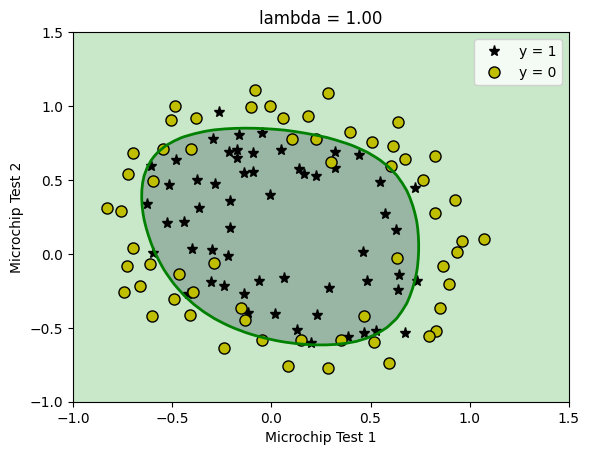

In [130]:
# Initialize fitting parameters
initial_theta = np.zeros(X.shape[1])

# Set regularization parameter lambda to 1 (you should vary this)
lambda_ = 1

# set options for optimize.minimize
options= {'maxiter': 100}

res = optimize.minimize(costFunctionReg,
                        initial_theta.flatten(),
                        (X, y.flatten(), lambda_),
                        jac=True,
                        method='TNC',
                        options=options)

# the fun property of OptimizeResult object returns
# the value of costFunction at optimized theta
cost = res.fun

# the optimized theta is in the x property of the result
theta = res.x

#utils.plotDecisionBoundary(plotData, theta, X, y)
u = np.linspace(-1, 1.5, 50)
v = np.linspace(-1, 1.5, 50)
z = np.zeros((len(u), len(v)))
plotData(X[:, 1:3], y)

def mapFeatureForPlotting(X1, X2):
    degree = 6
    out = np.ones(1)
    for i in range(1, degree+1):
        for j in range(i+1):
            out = np.hstack((out, np.multiply(np.power(X1, i-j), np.power(X2, j))))
    return out
for i in range(len(u)):
    for j in range(len(v)):
        z[i,j] = np.dot(mapFeatureForPlotting(u[i], v[j]), theta)

pyplot.xlabel('Microchip Test 1')
pyplot.ylabel('Microchip Test 2')
pyplot.legend(['y = 1', 'y = 0'])
pyplot.grid(False)
pyplot.title('lambda = %0.2f' % lambda_)
z = z.T  # important to transpose z before calling contour
# print(z)

# Plot z = 0
pyplot.contour(u, v, z, levels=[0], linewidths=2, colors='g')
pyplot.contourf(u, v, z, levels=[np.min(z), 0, np.max(z)], cmap='Greens', alpha=0.4)


# Compute accuracy on our training set
p = predict(theta, X)

print('Train Accuracy: %.1f %%' % (np.mean(p == y) * 100))
print('Expected accuracy (with lambda = 1): 83.1 % (approx)\n')


### 2.5 Regularização

Nesta parte nós mostraremos como os parâmetros de regularização, neste caso, o valor de $\lambda$, podem influenciar no limite de decisão e como elas funcionam para evitar *overfitting*.

Note que o limite de decisão varia a medida que $\lambda$ é alterado. Como esperado, com um $\lambda$ muito pequeno, você deve perceber que o classificador acerta todas as previsões de treinamento, mas desenha um limita complicado, causando *overfitting* nos dados.

Convidamos vocês a modificar o valor de lambda na célula acima e, assim, observar as consequências disto no limite de decisão. Entretanto, abaixo estão três imagens que ilustram um exemplo em que não há regularização (primeira), um exemplo em que a regularização possui parâmetros ajustados (segunda) e um exemplo em que há regularização em excesso (terceira).

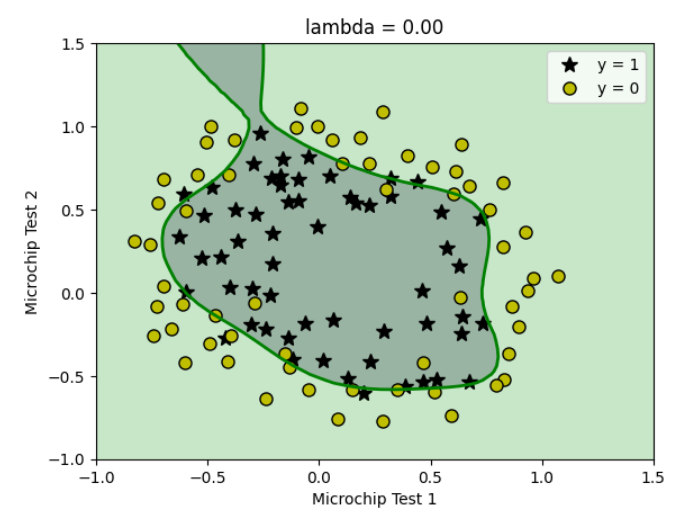

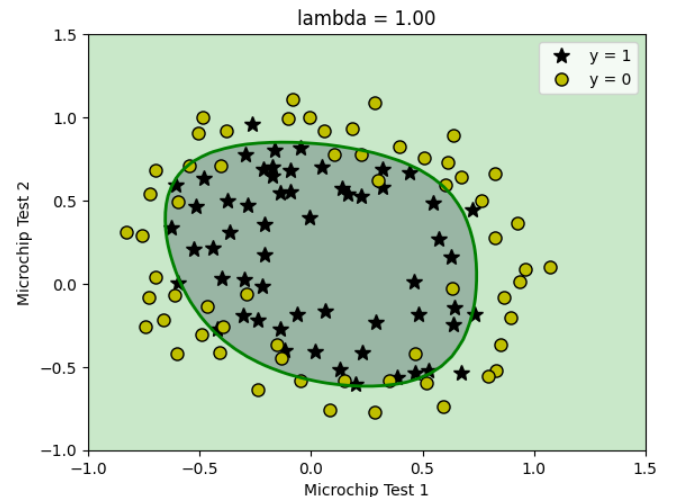

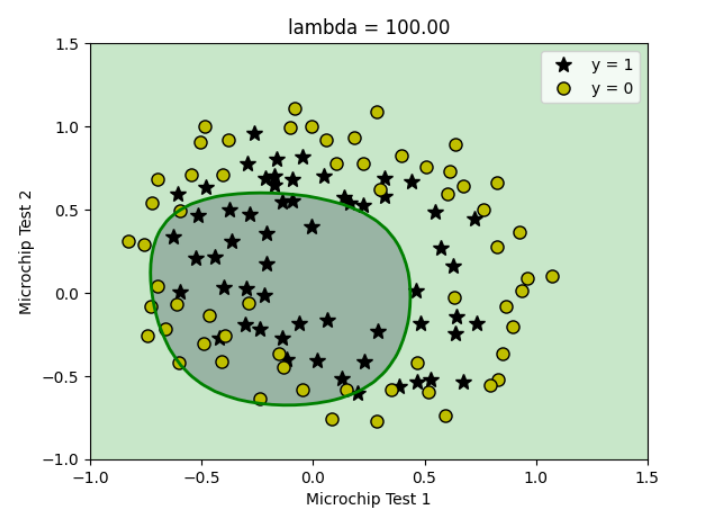